In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import LSTM, Dropout, Dense

# Setting up matplotlib parameters
%matplotlib inline
rcParams['figure.figsize'] = 20, 10

# Reading data from CSV file
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")

# Displaying the first few rows of the dataframe
df.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


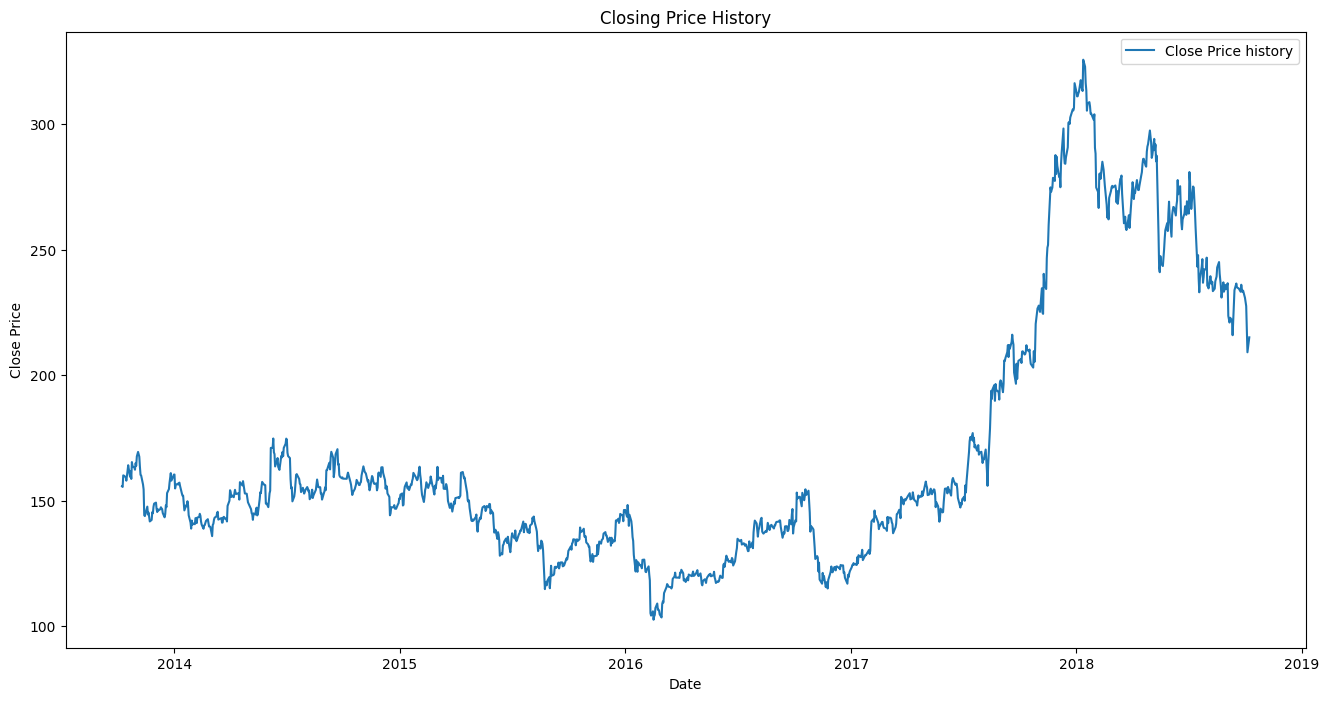

In [2]:
# Converting date column to datetime format and setting it as index
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']

# Plotting closing price history
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Close Price history')
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [3]:
# Preparing data for LSTM model
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)

# Displaying the prepared dataset
new_dataset.head()


,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


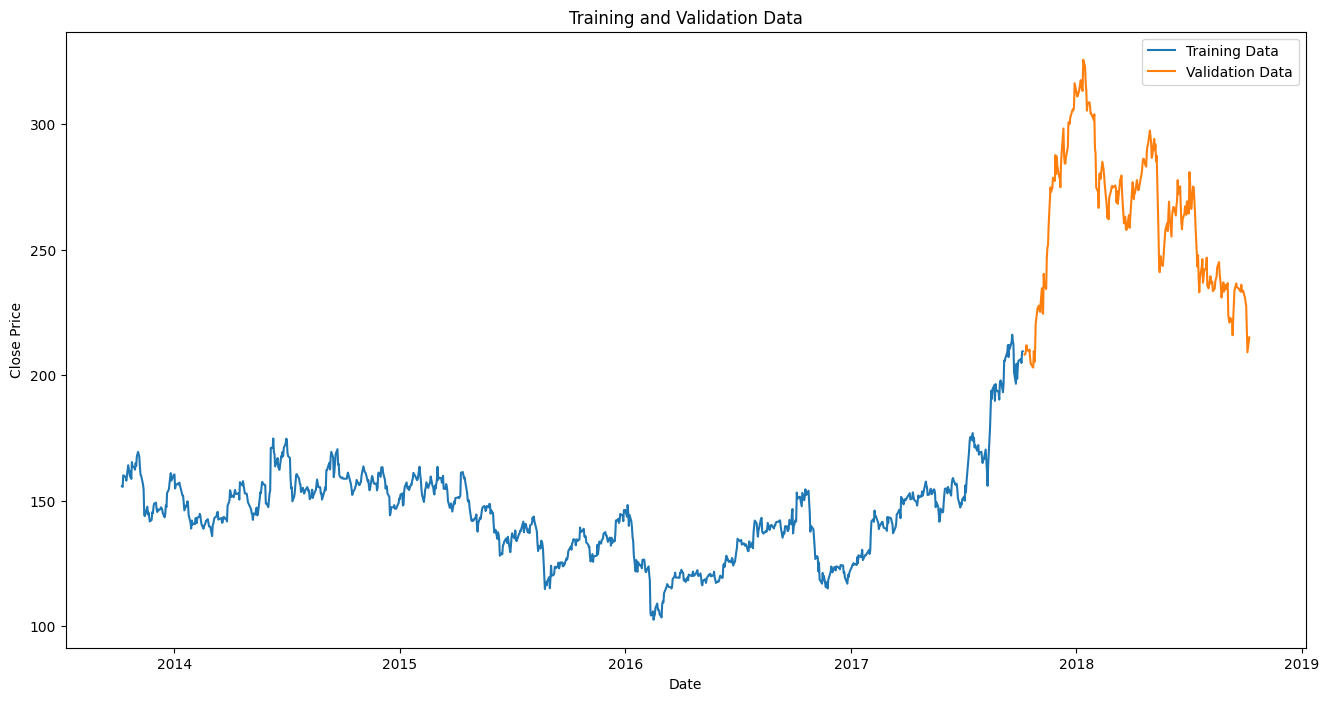

In [4]:
# Splitting the data into training and validation sets
final_dataset = new_dataset.values
train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

# Plotting training and validation data
plt.figure(figsize=(16, 8))
plt.plot(new_dataset[:987].index, train_data, label='Training Data')
plt.plot(new_dataset[987:].index, valid_data, label='Validation Data')
plt.title('Training and Validation Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [5]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# Preparing the training data for LSTM
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Displaying the shape of the training data
x_train_data.shape, y_train_data.shape


((927, 60, 1), (927,))

In [6]:
# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Training the LSTM model
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)


927/927 - 29s - loss: 0.0010 - 29s/epoch - 31ms/step


In [7]:
# Preparing validation data for predictions
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Making predictions
closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

8/8 [==============================] - 1s 15ms/step


<ipython-input-8-ca51100c8713>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data.loc[:, 'Predictions'] = closing_price


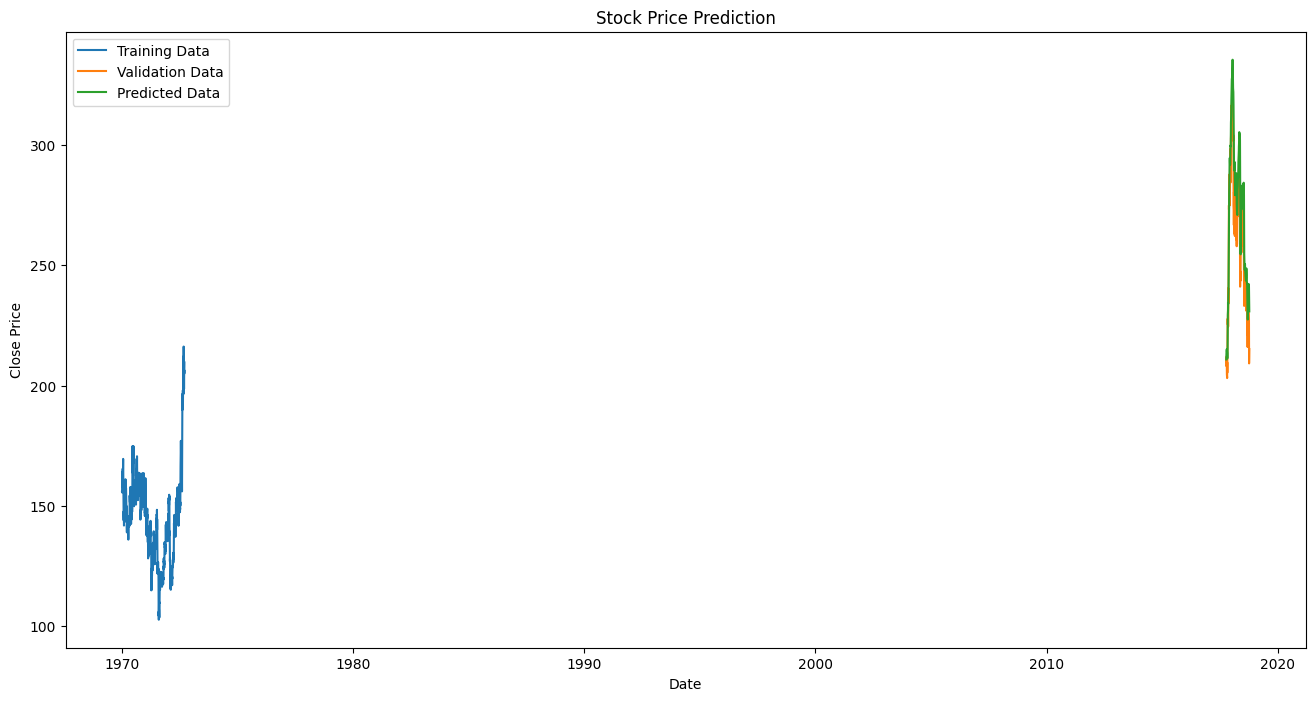

In [8]:
# Visualizing the predictions
valid_data = new_dataset[987:]
valid_data.loc[:, 'Predictions'] = closing_price

plt.figure(figsize=(16, 8))
plt.plot(train_data, label='Training Data')
plt.plot(valid_data[['Close']], label='Validation Data')
plt.plot(valid_data[['Predictions']], label='Predicted Data')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [9]:
# Printing the shapes of all involved datasets to debug
print("Shape of train_data:", train_data.shape)
print("Shape of valid_data:", valid_data.shape)
print("Shape of closing_price:", closing_price.shape)

# Printing first few rows of predictions to verify
print(valid_data.head())

Shape of train_data: (987, 1)
Shape of valid_data: (248, 2)
Shape of closing_price: (248, 1)
             Close  Predictions
Date                           
2017-10-09   208.3   210.844742
2017-10-10  208.45   211.880386
2017-10-11   209.4   212.605148
2017-10-12   212.0   213.235550
2017-10-13  210.25   214.175385


In [10]:
# Importing necessary libraries for evaluation


# Computing the Mean Squared Error
mse = mean_squared_error(valid_data['Close'], valid_data['Predictions'])
print('Mean Squared Error:', mse)

# Computing the Mean Absolute Error
mae = mean_absolute_error(valid_data['Close'], valid_data['Predictions'])
print('Mean Absolute Error:', mae)

# Computing the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)

# Printing the predictions and actual values for comparison
comparison = valid_data[['Close', 'Predictions']].head(10)
print(comparison)


Mean Squared Error: 198.23969300170032
Mean Absolute Error: 11.395354744695847
Root Mean Squared Error: 14.079761823329978
             Close  Predictions
Date                           
2017-10-09   208.3   210.844742
2017-10-10  208.45   211.880386
2017-10-11   209.4   212.605148
2017-10-12   212.0   213.235550
2017-10-13  210.25   214.175385
2017-10-16   209.6   214.765305
2017-10-17   210.3   214.993271
2017-10-18   206.8   215.143326
2017-10-19   204.6   214.590637
2017-10-23   203.1   213.434097


In [12]:
# Function to predict stock prices for user input dates
def predict_stock_prices(dates):
    dates = pd.to_datetime(dates)
    new_inputs_data = new_dataset.values
    new_inputs_data = new_inputs_data.reshape(-1, 1)
    new_inputs_data = scaler.transform(new_inputs_data)

    predictions = []
    for date in dates:
        new_X_test = new_inputs_data[-60:]
        new_X_test = np.reshape(new_X_test, (1, new_X_test.shape[0], 1))
        predicted_price = lstm_model.predict(new_X_test)
        predicted_price = scaler.inverse_transform(predicted_price)
        predictions.append((date, predicted_price[0][0]))
        new_inputs_data = np.append(new_inputs_data, predicted_price).reshape(-1, 1)
        new_inputs_data = scaler.transform(new_inputs_data)

    return predictions

# Getting user input for dates
user_input_dates = input("Enter the dates for prediction (comma-separated, YYYY-MM-DD): ")
user_input_dates = user_input_dates.split(",")
predictions = predict_stock_prices(user_input_dates)

# Printing the predictions
for date, price in predictions:
    print(f"Predicted closing price for {date.date()}: {price}")

Enter the dates for prediction (comma-separated, YYYY-MM-DD): 2024-06-03
1/1 [==============================] - 0s 26ms/step
Predicted closing price for 2024-06-03: 226.84396362304688


In [13]:
# Saving the model
lstm_model.save("saved_lstm_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
